In [138]:
import pandas as pd

FAKE NEWS DETECTION

***DATA DESCRIPTION


-id: unique id for a news article
-title: the title of a news article
-author: author of the news article
-text: the text of the article; could be incomplete
-label: a label that marks the article as potentially unreliable
-1:Unreliable - The article might have questionable information or sources.
-0: Reliable - The article is considered trustworthy and well-sourced.

LOADING MY IMPORTANT LIBRARIES

In [139]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from tpot import TPOTClassifier



import warnings
warnings.filterwarnings("ignore")

In [140]:
merged_df = pd.concat([pd.read_csv(r'C:\Users\Admin\OneDrive - Sol Plaatje University\Documents\2024\CAPSTONE PROJECT\fake news\train.csv'),
                       pd.read_csv(r'C:\Users\Admin\OneDrive - Sol Plaatje University\Documents\2024\CAPSTONE PROJECT\fake news\test.csv')],
                      ignore_index=True)


EXPLORATORY DATA ANALYSIS

In [141]:
merged_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0


In [142]:
merged_df.count()

id        26000
title     25320
author    23540
text      25954
label     20800
dtype: int64

In [143]:
merged_df.shape

(26000, 5)

In [144]:
merged_df.isnull().sum()

id           0
title      680
author    2460
text        46
label     5200
dtype: int64

Data pre-processing

In [145]:
# Drop rows where 'label' is missing
merged_df.dropna(subset=['label'], inplace=True)

# Verify the changes
print(merged_df.isnull().sum())


id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [146]:
# Download the stopwords dataset
nltk.download('stopwords')

# Get the list of stopwords in English
stop_words = set(stopwords.words('english'))

# Example function to preprocess text
def preprocess_text(text):
    # Tokenize the text into words
    words = text.split()
    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the filtered words back into a single string
    return ' '.join(filtered_words)

# Example usage with a DataFrame containing news articles
train_news = pd.DataFrame({
    'text': [
        'This is a sample news article.',
        'Another example of a news story.'
    ]
})

# Apply the preprocessing function to the text column
train_news['processed_text'] = train_news['text'].apply(preprocess_text)

print(train_news[['text', 'processed_text']])

                               text               processed_text
0    This is a sample news article.         sample news article.
1  Another example of a news story.  Another example news story.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#stemming

Stemming is the process of reducing a word to its Root word

example: actor, actress, acting --> act

In [147]:
port_stem = PorterStemmer()

In [148]:
def stemming(content):
    # Replace all non-alphabetical characters with a space
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    
    # Convert text to lowercase
    stemmed_content = stemmed_content.lower()
    
    # Split the content into individual words
    stemmed_content = stemmed_content.split()
    
    # Apply stemming and remove stopwords
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if word not in stopwords.words('english')]
    
    # Join the stemmed words back into a string
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content


In [149]:
# Check if 'title', 'author', and 'text' columns exist in the dataframe
print(merged_df.columns)

# Combine 'title', 'author', and 'text' into a new column 'combined_text'
merged_df['combined_text'] = merged_df['title'].fillna('') + ' ' + merged_df['author'].fillna('') + ' ' + merged_df['text'].fillna('')

# Fill NaN values in 'combined_text' with an empty string (just in case)
merged_df['combined_text'] = merged_df['combined_text'].fillna('')

# Define the stemming function if not done already
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Apply the stemming function to the 'combined_text' column
merged_df['combined_text'] = merged_df['combined_text'].apply(lambda x: stemming(str(x)))


Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [150]:
print(merged_df['combined_text'])

0        hous dem aide: we didn’t even see comey’ lette...
1        flynn: hillari clinton, big woman on campu - b...
2        whi the truth might get you fire consortiumnew...
3        15 civilian kill in singl us airstrik have bee...
4        iranian woman jail for fiction unpublish stori...
                               ...                        
20795    rapper t.i.: trump a ’poster child for white s...
20796    n.f.l. playoffs: schedule, matchup and odd - t...
20797    macy’ is said to receiv takeov approach by hud...
20798    nato, russia to hold parallel exercis in balka...
20799    what keep the f-35 aliv david swanson david sw...
Name: combined_text, Length: 20800, dtype: object


In [151]:
#separating the data and label
X =merged_df['combined_text'].values
Y =merged_df['label'].values

In [152]:
print(X)

['hous dem aide: we didn’t even see comey’ letter until jason chaffetz tweet it darrel lucu hous dem aide: we didn’t even see comey’ letter until jason chaffetz tweet it by darrel lucu on octob 30, 2016 subscrib jason chaffetz on the stump in american fork, utah ( imag courtesi michael jolley, avail under a creativ commons-bi license) with apolog to keith olbermann, there is no doubt who the worst person in the world is thi week–fbi director jame comey. but accord to a hous democrat aide, it look like we also know who the second-worst person is as well. it turn out that when comey sent hi now-infam letter announc that the fbi wa look into email that may be relat to hillari clinton’ email server, the rank democrat on the relev committe didn’t hear about it from comey. they found out via a tweet from one of the republican committe chairmen. as we now know, comey notifi the republican chairmen and democrat rank member of the hous intelligence, judiciary, and oversight committe that hi age

In [153]:
print(Y)

[1. 0. 1. ... 0. 1. 1.]


DATA VISUALISATION

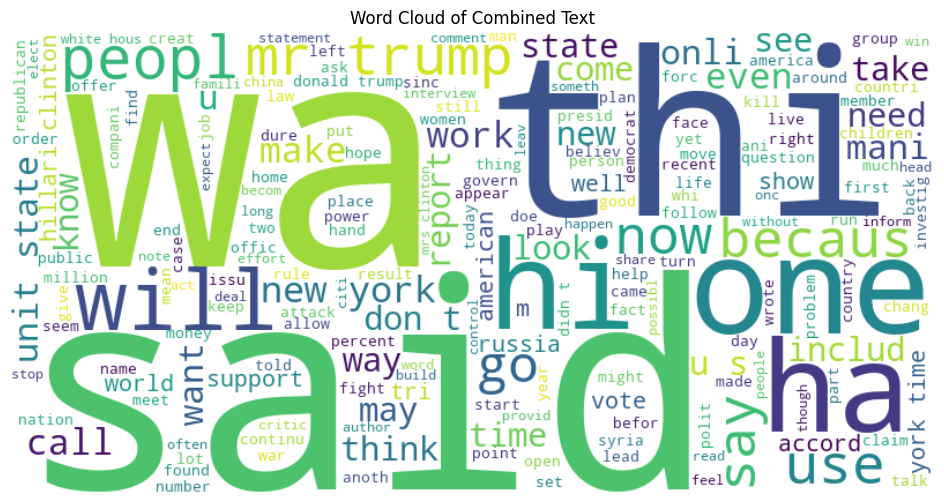

In [154]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text data
all_text = ' '.join(merged_df['combined_text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Combined Text')
plt.show()


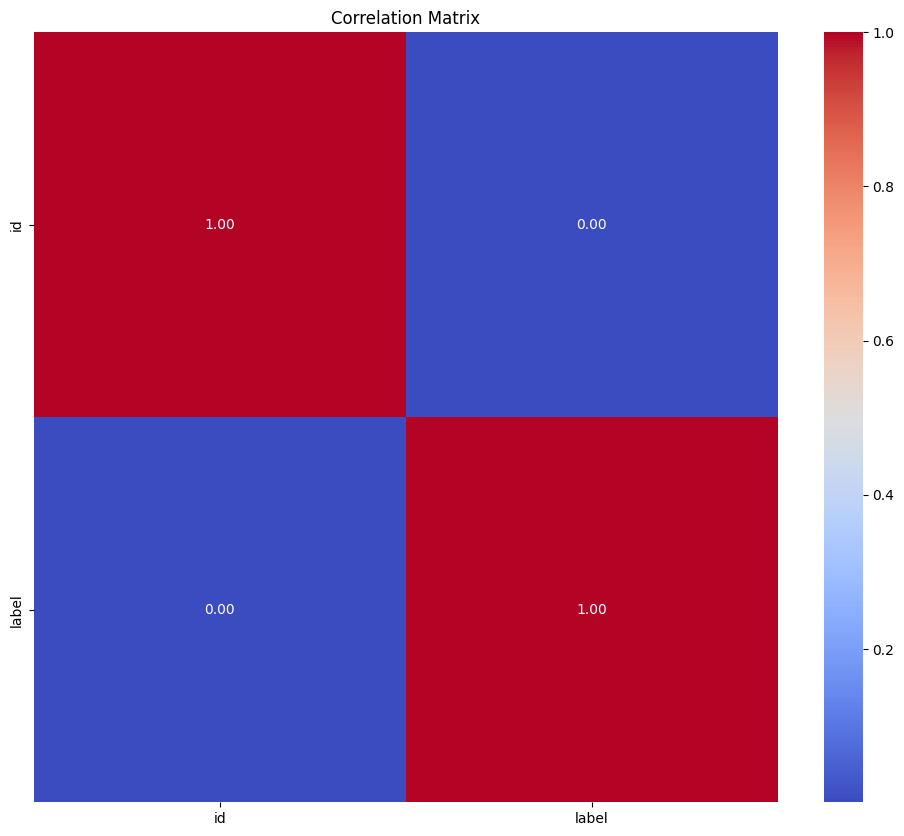

In [155]:
# Select only numeric columns
numeric_df = merged_df.select_dtypes(include=[float, int])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()



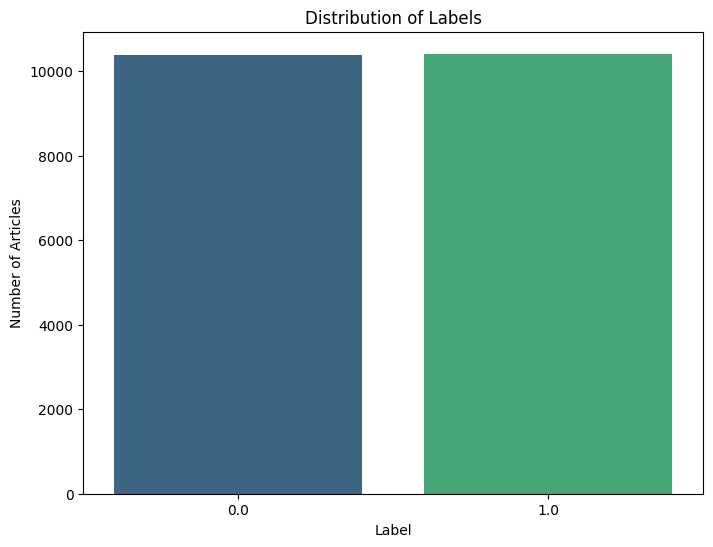

In [156]:
# Count the number of articles for each label
label_counts = merged_df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Number of Articles')
plt.show()



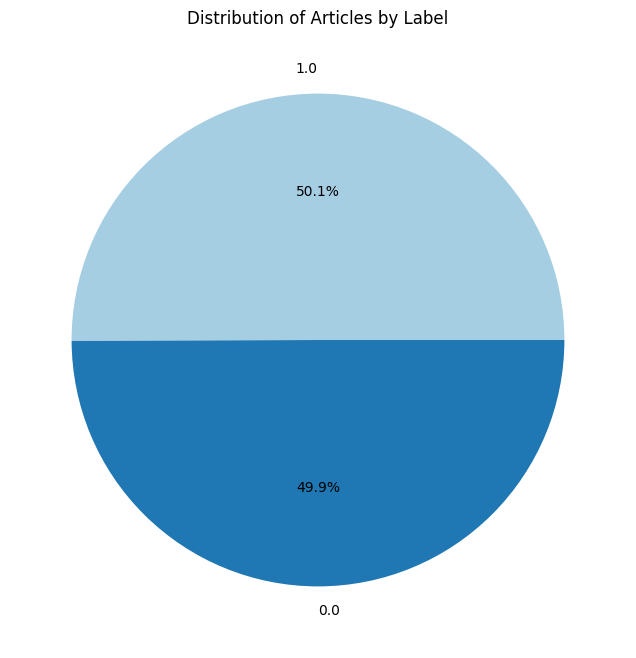

In [157]:
# Count the number of articles for each label
label_counts = merged_df['label'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(label_counts))))
plt.title('Distribution of Articles by Label')
plt.show()


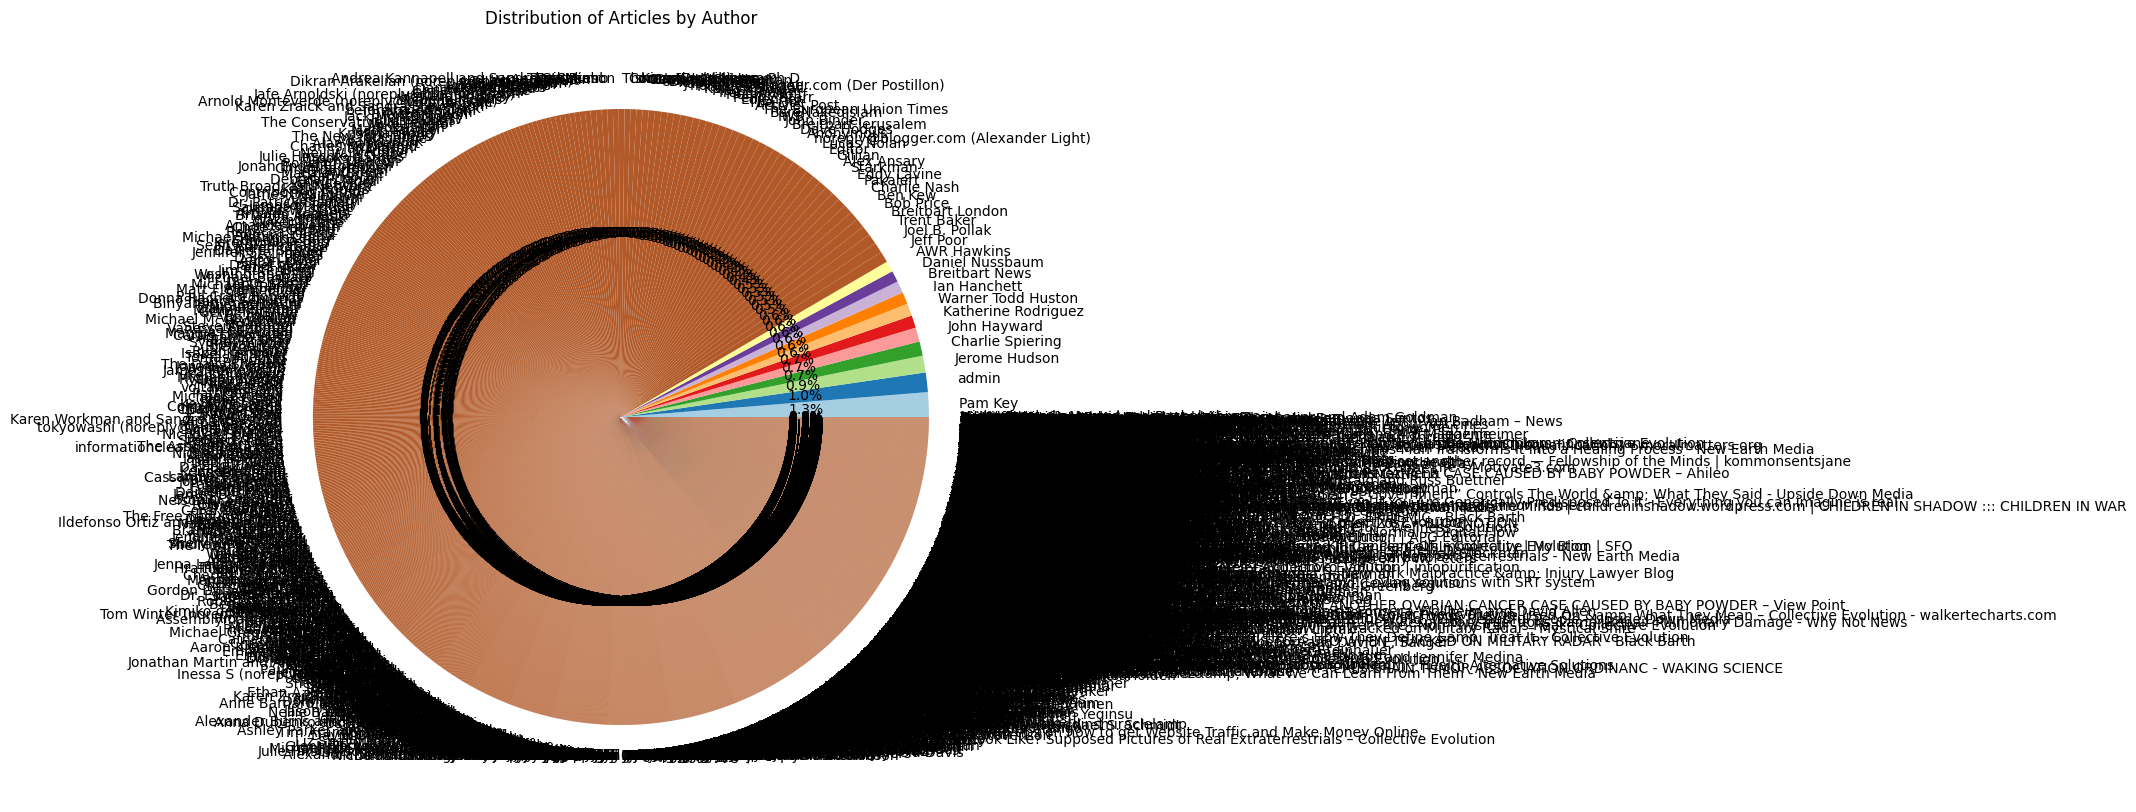

In [158]:
# Count the number of articles by each author
author_counts = merged_df['author'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(author_counts, labels=author_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(range(len(author_counts))))
plt.title('Distribution of Articles by Author')
plt.show()


In [159]:
# Sample DataFrame creation (replace this with your actual data)
data = {
    'id': [1, 2, 3, 4, 5],
    'title': ['A', 'B', 'C', 'D', 'E'],
    'author': ['Author1', 'Author2', 'Author1', 'Author3', 'Author2'],
    'text': ['Text1', 'Text2', 'Text3', 'Text4', 'Text5'],
    'label': ['Science', 'Politics', 'Science', 'Sports', 'Politics'],
    'has_image': [True, False, True, True, False]
}
df = pd.DataFrame(data)

# Count articles by label and whether they have images
image_counts = df.groupby(['label', 'has_image']).size().unstack(fill_value=0)

# Print counts
print(image_counts)


has_image  False  True 
label                  
Politics       2      0
Science        0      2
Sports         0      1


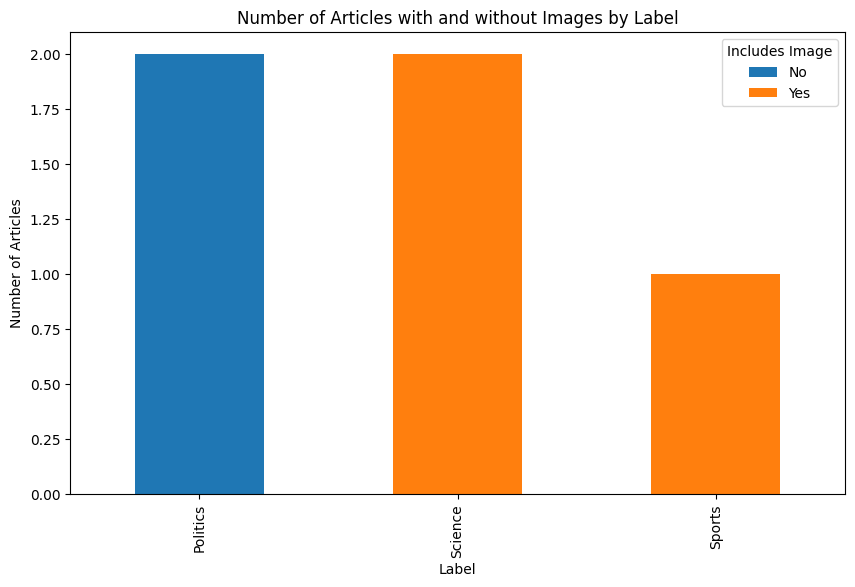

In [160]:
# Plot a stacked bar chart
image_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Articles with and without Images by Label')
plt.xlabel('Label')
plt.ylabel('Number of Articles')
plt.legend(title='Includes Image', labels=['No', 'Yes'])
plt.show()


In [161]:
merged_df.columns = merged_df.columns.str.strip()  


In [162]:
from sklearn.model_selection import train_test_split

# Separate the features (data) and labels
X = merged_df['combined_text'].values  # Features: text data
Y = merged_df['label'].values          # Labels: classification labels

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Print the number of samples in the training and testing datasets
print(f"Number of samples in the training set: {X_train.shape[0]}")
print(f"Number of samples in the testing set: {X_test.shape[0]}")

Number of samples in the training set: 16640
Number of samples in the testing set: 4160


In [163]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Compute TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Shape of the sparse matrix
print("TF-IDF matrix shape:", X_tfidf.shape)


TF-IDF matrix shape: (20800, 178998)


In [164]:

X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Separate the features (data) and labels
X = X_tfidf  # Keep it as a sparse matrix
Y = merged_df['label'].values

# Split the TF-IDF data into training and testing sets
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Define and train the model
def train(model, model_name):
    model.fit(X_train_tfidf, Y_train)
    model_train_score = model.score(X_train_tfidf, Y_train)
    model_test_score = model.score(X_test_tfidf, Y_test)
    print(f"{model_name} model score on Training data: {model_train_score * 100:.2f}%")
    print(f"{model_name} model score on Testing data: {model_test_score * 100:.2f}%")

# Perform k-fold cross-validation
def kfolds(model, model_name):
    scores = cross_val_score(model, X_tfidf, Y, cv=10)
    model_score = np.average(scores)
    print(f"{model_name} score on cross-validation: {model_score * 100:.2f}%")

# Initialize and train the KNN model
knn = KNeighborsClassifier()
train(knn, "KNN")
kfolds(knn, "KNN")


KNN model score on Training data: 87.01%
KNN model score on Testing data: 81.63%
KNN score on cross-validation: 82.16%


CONVERTING THE TEXTUAL DATA  TO NUMERICAL USING TF-IDF AND MODEL DEPLOYMENT

In [165]:
from sklearn.decomposition import TruncatedSVD

# Initialize TF-IDF Vectorizer with a limited number of features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Apply TruncatedSVD to further reduce dimensionality
svd = TruncatedSVD(n_components=100)  
X_reduced = svd.fit_transform(X_tfidf)

print(f"Reduced TF-IDF matrix shape: {X_reduced.shape}")


Reduced TF-IDF matrix shape: (20800, 100)


In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Initialize TF-IDF Vectorizer with a limited number of features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Apply TruncatedSVD to further reduce dimensionality
svd = TruncatedSVD(n_components=100)  
X_reduced = svd.fit_transform(X_tfidf)

# Print the shape of the reduced TF-IDF matrix
print(f"Reduced TF-IDF matrix shape: {X_reduced.shape}")

# Separate the labels
Y = merged_df['label'].values

# Split the reduced data into training and testing sets
X_train_reduced, X_test_reduced, Y_train, Y_test = train_test_split(
    X_reduced, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Define the KNN model
knn = KNeighborsClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Example values for KNN hyperparameter
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_reduced, Y_train)

# Get the best parameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score * 100:.2f}%")


Reduced TF-IDF matrix shape: (20800, 100)
Best parameters found: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 90.96%


In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Initialize TF-IDF Vectorizer with a limited number of features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Apply TruncatedSVD to further reduce dimensionality
svd = TruncatedSVD(n_components=100)  
X_reduced = svd.fit_transform(X_tfidf)

# Separate the labels
Y = merged_df['label'].values

# Split the reduced data into training and testing sets
X_train_reduced, X_test_reduced, Y_train, Y_test = train_test_split(
    X_reduced, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Define the KNN model
knn = KNeighborsClassifier()

# Define hyperparameters to tune (ensure 'p' is not included unless you want to specify it)
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Example values for KNN hyperparameter
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Include this if you want to tune the power parameter as well
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_reduced, Y_train)

# Get the best parameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print only the best parameters and cross-validation score
print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score:.2f}")


Best parameters found: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
Best cross-validation score: 0.91


In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize TF-IDF Vectorizer with a limited number of features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Apply TruncatedSVD to further reduce dimensionality
svd = TruncatedSVD(n_components=100)  
X_reduced = svd.fit_transform(X_tfidf)

# Print the shape of the reduced TF-IDF matrix
print(f"Reduced TF-IDF matrix shape: {X_reduced.shape}")

# Separate the labels
Y = merged_df['label'].values

# Split the reduced data into training and testing sets
X_train_reduced, X_test_reduced, Y_train, Y_test = train_test_split(
    X_reduced, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Define the KNN model
knn = KNeighborsClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train_reduced, Y_train)

# Get the best parameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best cross-validation score: {best_score * 100:.2f}%")

# Retrain the KNN model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train_reduced, Y_train)

# Make predictions on the test set
Y_pred = best_knn.predict(X_test_reduced)

# Evaluate the model
test_accuracy = accuracy_score(Y_test, Y_pred)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))


Reduced TF-IDF matrix shape: (20800, 100)
Best parameters found: {'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score: 91.16%
Test set accuracy: 91.39%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      2077
         1.0       0.91      0.92      0.91      2083

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160

Confusion Matrix:
 [[1890  187]
 [ 171 1912]]


In [169]:
naive_bayes = MultinomialNB()
kfolds(naive_bayes, "Naive_Bayes")
train(naive_bayes, "Naive_Bayes")

Naive_Bayes score on cross-validation: 91.64%
Naive_Bayes model score on Training data: 88.31%
Naive_Bayes model score on Testing data: 84.06%


Naive Bayes Test set accuracy: 91.73%

Naive Bayes Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.96      0.92      2077
         1.0       0.96      0.87      0.91      2083

    accuracy                           0.92      4160
   macro avg       0.92      0.92      0.92      4160
weighted avg       0.92      0.92      0.92      4160



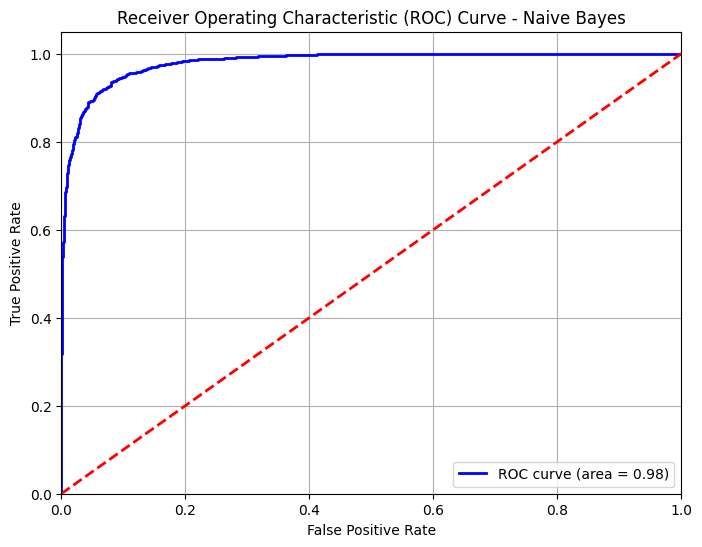

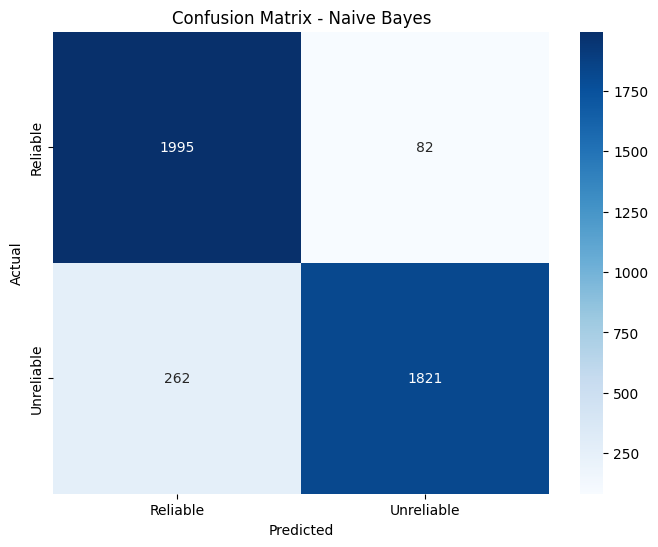

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualization of the confusion matrix

# 1. Initialize and fit TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limiting to 10,000 features
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])  
Y = merged_df['label'].values

# 2. Split into training and test sets
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(
    X_tfidf, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# 3. Initialize the Naive Bayes model
naive_bayes = MultinomialNB()

# 4. Train the model
naive_bayes.fit(X_train_tfidf, Y_train)

# 5. Make predictions on the test set
Y_pred_nb = naive_bayes.predict(X_test_tfidf)

# 6. Evaluate the model
test_accuracy_nb = accuracy_score(Y_test, Y_pred_nb)
print(f"Naive Bayes Test set accuracy: {test_accuracy_nb * 100:.2f}%")

# 7. Print classification report
print("\nNaive Bayes Classification Report:\n", classification_report(Y_test, Y_pred_nb))

# 8. Calculate ROC Curve
Y_prob_nb = naive_bayes.predict_proba(X_test_tfidf)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_nb)
roc_auc = auc(fpr, tpr)

# 9. Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 10. Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_nb)

# 11. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Reliable', 'Unreliable'], 
            yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


Shape of X_tfidf: (20800, 10000)
Shape of X_train_tfidf: (16640, 10000)
Shape of Y_train: (16640,)
Test set accuracy: 96.15%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2077
         1.0       0.96      0.97      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



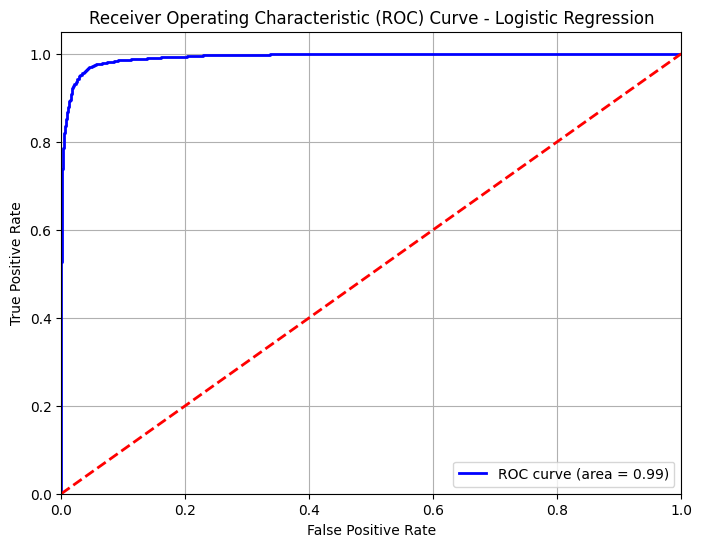

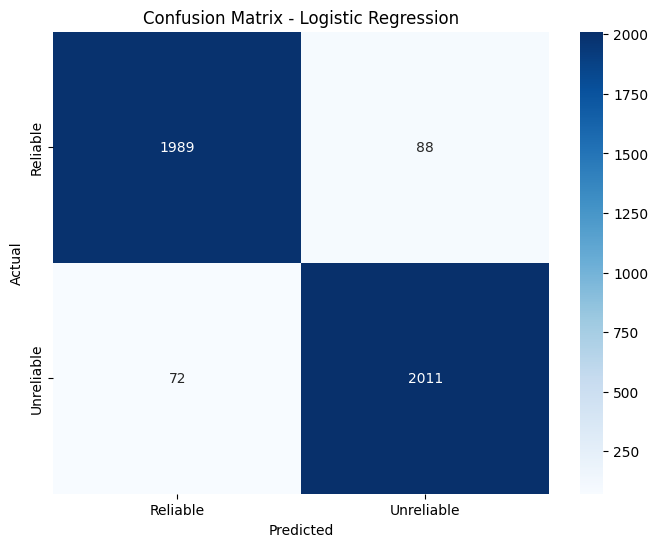

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns  # For better visualization of the confusion matrix

# Step 3: Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_df['combined_text'])

# Check the shape of the TF-IDF matrix
print(f"Shape of X_tfidf: {X_tfidf.shape}")  # Should be (20800, n_features)

# Step 4: Separate the labels
Y = merged_df['label'].values

# Step 5: Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(
    X_tfidf, Y, 
    test_size=0.2, 
    stratify=Y, 
    random_state=42
)

# Step 6: Check shapes after splitting
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")  # Should be (16640, n_features)
print(f"Shape of Y_train: {Y_train.shape}")  # Should be (16640,)

# Step 7: Define the Logistic Regression model
best_params_lr = {'C': 1.0, 'solver': 'lbfgs'}  # Replace with actual best params

# Step 8: Retrain the Logistic Regression model
lr_model = LogisticRegression(**best_params_lr, max_iter=1000)
lr_model.fit(X_train_tfidf, Y_train)

# Step 9: Make predictions on the test set
Y_pred_lr = lr_model.predict(X_test_tfidf)

# Step 10: Evaluate the model
test_accuracy = accuracy_score(Y_test, Y_pred_lr)
print(f"Test set accuracy: {test_accuracy * 100:.2f}%")

# Step 11: Print classification report
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_lr))

# Step 12: Calculate ROC Curve
Y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Get probabilities for the positive class
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_lr)
roc_auc = auc(fpr, tpr)

# Step 13: Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Step 14: Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_lr)

# Step 15: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Reliable', 'Unreliable'], 
            yticklabels=['Reliable', 'Unreliable'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


KNN Test Accuracy: 90.82%
KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      2077
         1.0       0.91      0.91      0.91      2083

    accuracy                           0.91      4160
   macro avg       0.91      0.91      0.91      4160
weighted avg       0.91      0.91      0.91      4160



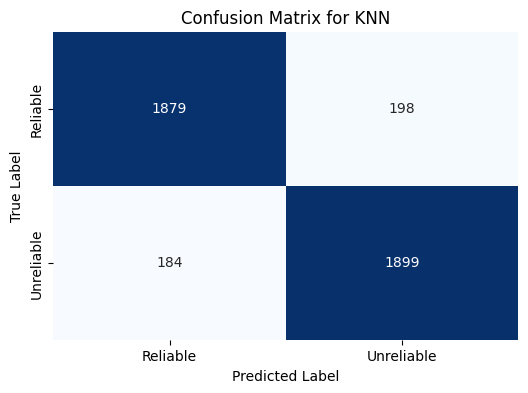

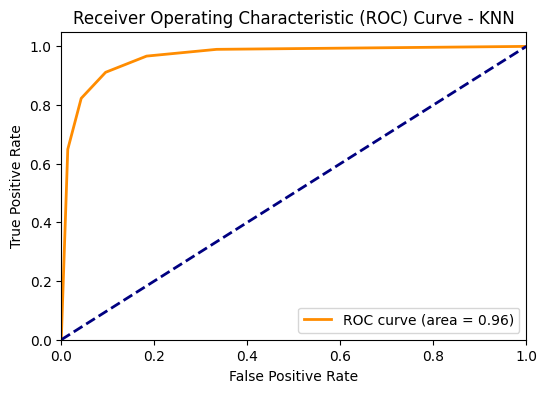

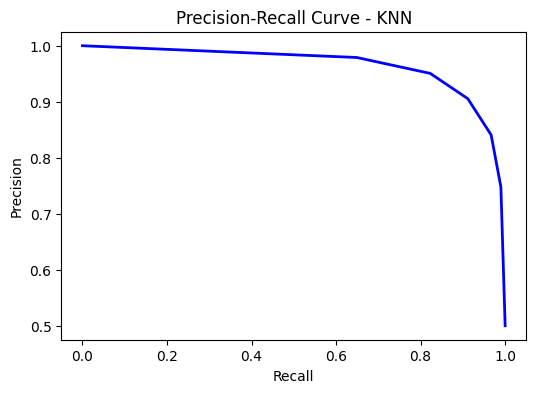

In [172]:
# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_reduced, Y_train)

# Predict and evaluate the model
Y_pred_knn = knn_model.predict(X_test_reduced)
Y_pred_prob_knn = knn_model.predict_proba(X_test_reduced)[:, 1] 

# Print accuracy and classification report
print(f"KNN Test Accuracy: {accuracy_score(Y_test, Y_pred_knn) * 100:.2f}%")
print("KNN Classification Report:\n", classification_report(Y_test, Y_pred_knn))

# Plot confusion matrix
conf_matrix_knn = confusion_matrix(Y_test, Y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(Y_test, Y_pred_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(6, 4))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision_knn, recall_knn, _ = precision_recall_curve(Y_test, Y_pred_prob_knn)

plt.figure(figsize=(6, 4))
plt.plot(recall_knn, precision_knn, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN')
plt.show()


In [173]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, Y_train)

# Predict and evaluate the model
Y_pred_rf = rf_model.predict(X_test_tfidf)
print(f"Random Forest Test Accuracy: {accuracy_score(Y_test, Y_pred_rf) * 100:.2f}%")
print("Random Forest Classification Report:\n", classification_report(Y_test, Y_pred_rf))


Random Forest Test Accuracy: 96.30%
Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2077
         1.0       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



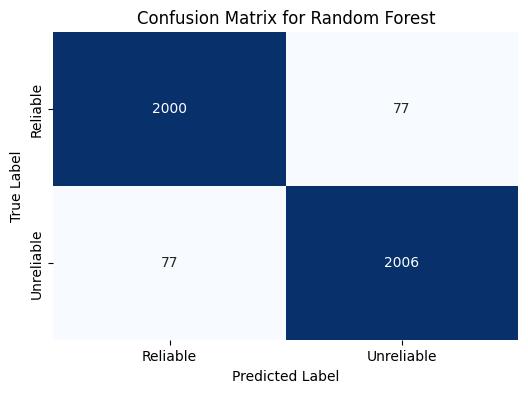

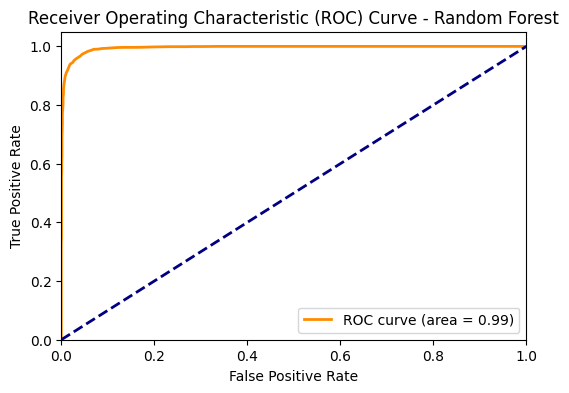

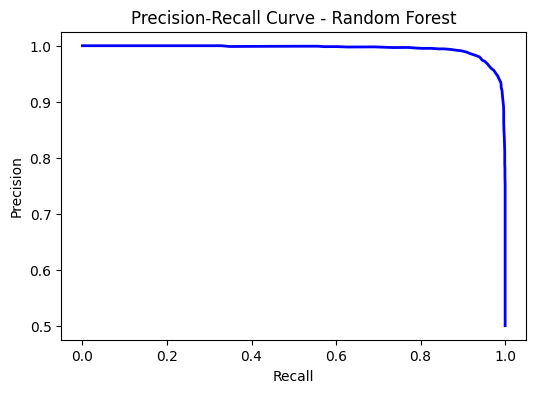

In [174]:
# Predict the model
Y_pred_rf = rf_model.predict(X_test_tfidf)
Y_pred_prob_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

# Confusion Matrix
conf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot 1: ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Plot 2: Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(Y_test, Y_pred_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(recall_rf, precision_rf, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.show()


In [175]:
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, Y_train)

# Predict and evaluate the model
Y_pred_svm = svm_model.predict(X_test_tfidf)
print(f"SVM Test Accuracy: {accuracy_score(Y_test, Y_pred_svm) * 100:.2f}%")
print("SVM Classification Report:\n", classification_report(Y_test, Y_pred_svm))


SVM Test Accuracy: 97.04%
SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2077
         1.0       0.97      0.97      0.97      2083

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



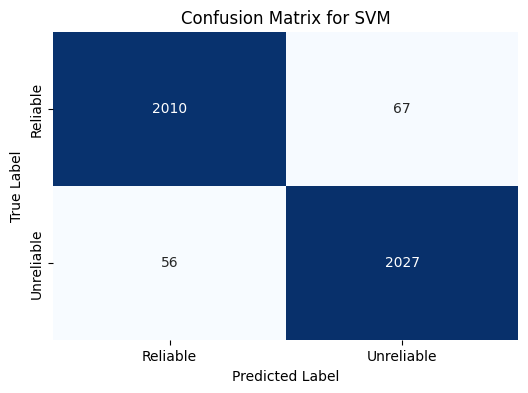

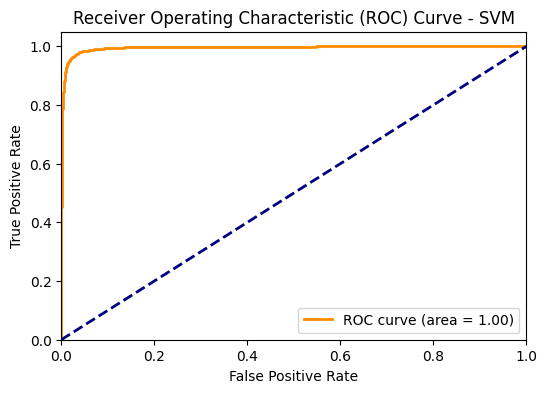

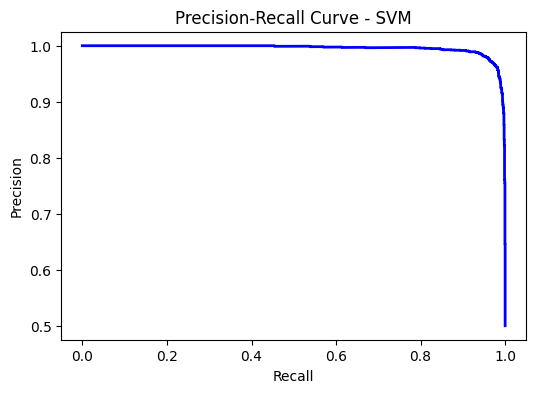

In [176]:
# Initialize and train the SVM model with probability estimates enabled
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, Y_train)

# Predict the model
Y_pred_svm = svm_model.predict(X_test_tfidf)

# Use decision_function to get scores for ROC and Precision-Recall curves
Y_scores_svm = svm_model.decision_function(X_test_tfidf)

# Confusion Matrix
conf_matrix_svm = confusion_matrix(Y_test, Y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot 1: ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(Y_test, Y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 4))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc="lower right")
plt.show()

# Plot 2: Precision-Recall Curve
precision_svm, recall_svm, _ = precision_recall_curve(Y_test, Y_scores_svm)

plt.figure(figsize=(6, 4))
plt.plot(recall_svm, precision_svm, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM')
plt.show()


In [177]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train_tfidf, Y_train)

# Predict and evaluate the model
Y_pred_gb = gb_model.predict(X_test_tfidf)
print(f"Gradient Boosting Test Accuracy: {accuracy_score(Y_test, Y_pred_gb) * 100:.2f}%")
print("Gradient Boosting Classification Report:\n", classification_report(Y_test, Y_pred_gb))


Gradient Boosting Test Accuracy: 96.47%
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      2077
         1.0       0.95      0.98      0.97      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



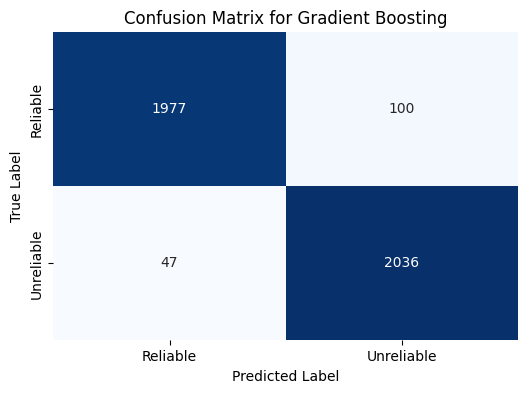

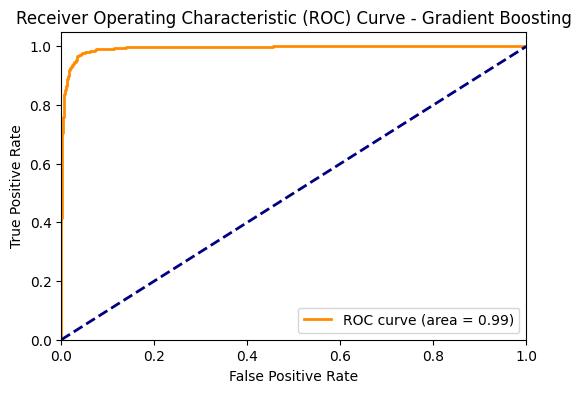

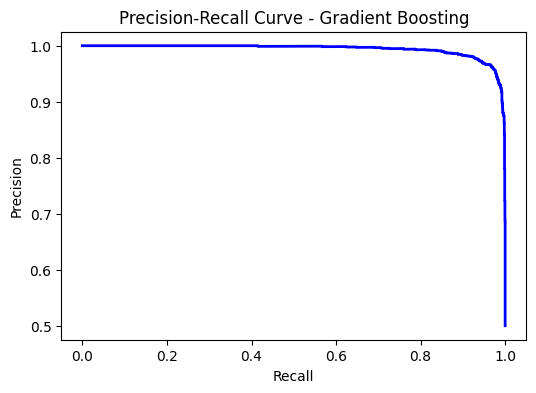

In [178]:

Y_pred_gb = gb_model.predict(X_test_tfidf)

# Get probabilities for the positive class (unreliable news)
Y_pred_prob_gb = gb_model.predict_proba(X_test_tfidf)[:, 1]

# Confusion Matrix
conf_matrix_gb = confusion_matrix(Y_test, Y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Reliable', 'Unreliable'], yticklabels=['Reliable', 'Unreliable'])
plt.title('Confusion Matrix for Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot 1: ROC Curve
fpr_gb, tpr_gb, _ = roc_curve(Y_test, Y_pred_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

# Plot 2: Precision-Recall Curve
precision_gb, recall_gb, _ = precision_recall_curve(Y_test, Y_pred_prob_gb)

plt.figure(figsize=(6, 4))
plt.plot(recall_gb, precision_gb, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Gradient Boosting')
plt.show()



In [179]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Assuming 'merged_df' contains the dataset with 'combined_text' and 'label'
X = merged_df['combined_text'].values
y = merged_df['label'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
max_sequence_len = 200  
X_padded = pad_sequences(X_seq, maxlen=max_sequence_len)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Save the tokenizer for later use in the Gradio app
joblib.dump(tokenizer, 'tokenizer.pkl')

# Build the CNN model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the CNN model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Save the trained model for later use
model.save('cnn_model.h5')


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 78s 292ms/step - accuracy: 0.7564 - loss: 0.4362 - val_accuracy: 0.9365 - val_loss: 0.1506
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 75s 288ms/step - accuracy: 0.9720 - loss: 0.0783 - val_accuracy: 0.9524 - val_loss: 0.1244
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 75s 287ms/step - accuracy: 0.9974 - loss: 0.0136 - val_accuracy: 0.9526 - val_loss: 0.1339
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 76s 292ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.9546 - val_loss: 0.1453
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 76s 291ms/step - accuracy: 0.9998 - loss: 0.0023 - val_accuracy: 0.9546 - val_loss: 0.1529


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


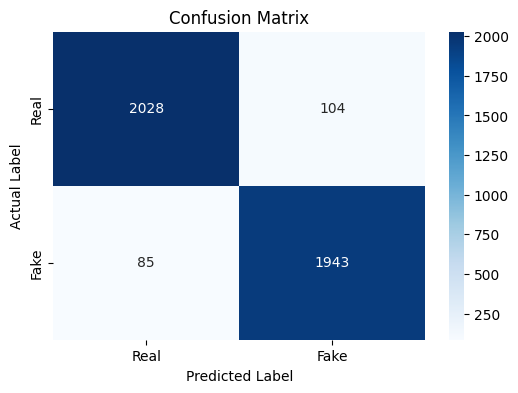

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2132
           1       0.95      0.96      0.95      2028

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160

Test Accuracy: 95.46%


In [180]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred_cnn = model.predict(X_test)
y_pred_labels = (y_pred_cnn >= 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

# Test accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


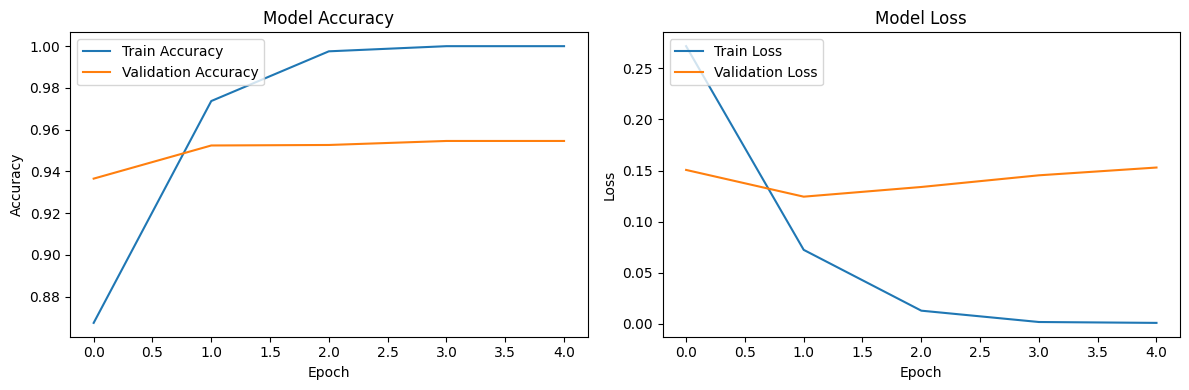

In [181]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


CONVERTING MY PROJECT THE REAL WORLD

GRADIO APP

In [182]:
import gradio as gr
import joblib

# Load the trained model and TF-IDF vectorizer
rf_model = joblib.load('rf_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Define the prediction function
def predict_news(input_text):
    # Transform the input text using the TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([input_text])
    # Predict using the trained Random Forest model
    prediction = rf_model.predict(text_tfidf)[0]
    # Return the prediction result: Real News (0) or Fake News (1)
    return "Real News" if prediction == 0 else "Fake News"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(label="Enter news text here...", placeholder="Type your news here..."),
    outputs="text",
    title="News Classification",
    description="Enter the news text to classify it as Real News or Fake News."
)

# Launch the Gradio app
if __name__ == '__main__':
    iface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
